In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import pathpatch_2d_to_3d, Poly3DCollection
import numpy as np
try:
    import open3d as o3d
except ImportError:
    import sys
    print(sys.exc_info())
import pandas as pd
from scipy import interpolate

from dosipy.utils.dataloader import load_ear_data
from dosipy.utils.integrate import elementwise_quad, elementwise_dblquad
from dosipy.utils.viz import (set_colorblind, save_fig, scatter_2d, scatter_3d,
                              fig_config, set_axes_equal)
from helpers import (clean_df, export_pcd, export_fields,
                     poynting_vector, get_imcolors, export_rect_idx)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
set_colorblind()
%config InlineBackend.figure_format = 'retina'

# APD distribution

In [ ]:
origin_ds = {'te26_4': [-25.28, 17.25],
             'tm26_4': [-19.77, 5.22],
             'te60_4': [-25.09, 19.09],
             'te60_1': [-8.50, 11.38],
             'tm60_4': [-13.24, 13.05],
             'tm60_1': [-10.32, 13.46],
             }

In [ ]:
# input data

polarization = 'te'
f = 26
edge_length = 20

In [ ]:
if edge_length == 20:
    A = 4
    origin = origin_ds[f'{polarization}{f}_{A}']
elif edge_length == 10:
    A = 1
    origin = origin_ds[f'{polarization}{f}_{A}']
else:
    raise ValueError(f'Edge length {edge_length} is not defined.')

In [77]:
# load surface data

df = load_ear_data(polarization, f, surface='front')
df = clean_df(df)
xyz = export_pcd(df)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)

# postprocessing on the surface of the model

E, H = export_fields(df)
Sx, Sy, Sz = poynting_vector(E, H)
pcd.estimate_normals()
n = np.asarray(pcd.normals)
APD = np.abs(Sx.real * n[:, 0] + Sy.real * n[:, 1] + Sz.real * n[:, 2])

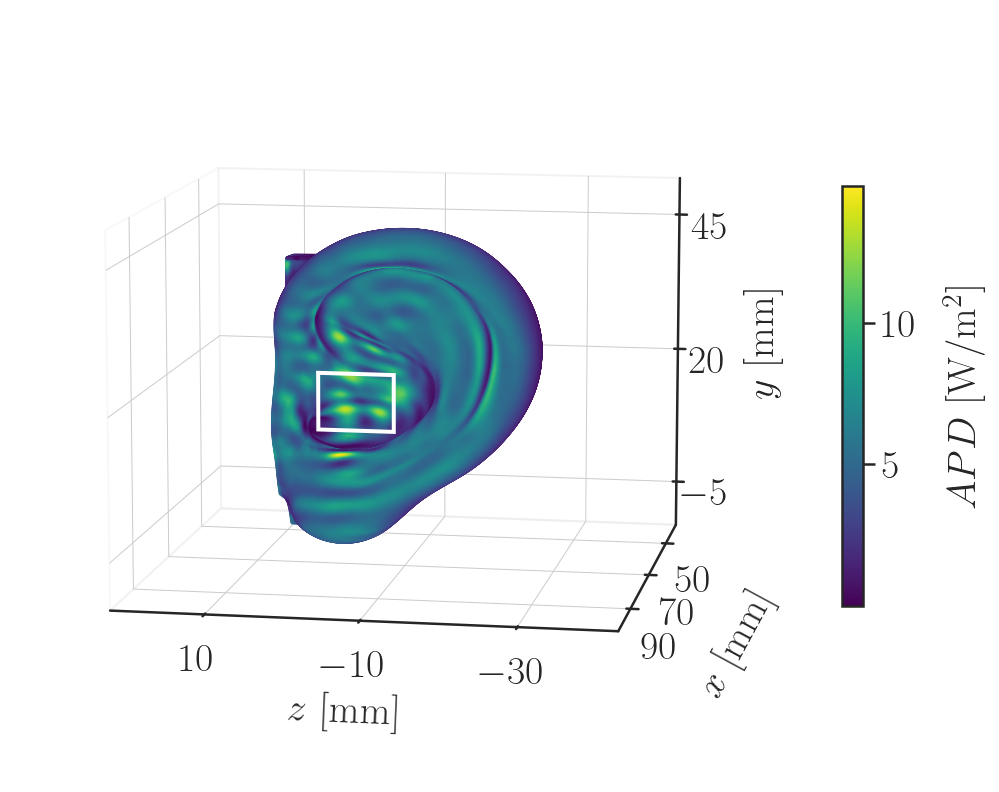

In [78]:
skip = 1
scaler = 2
fig_config(latex=True, text_size=20, scaler=scaler)
fig = plt.figure()
ax = plt.axes(projection ='3d')

# point cloud and apd spatial distribution
cs = ax.scatter(xyz[::skip, 2], xyz[::skip, 0], xyz[::skip, 1],
                c=APD[::skip],
                cmap='viridis',
                s=0.5,
               )

# averaging surface(s)
rect_pos = xyz[:, 0].max()
if (f == 60) and (edge_length == 20):
    patch_rect = Rectangle(origin, edge_length, edge_length, fc='None', lw=2)
    origin_red = [origin[0] + edge_length / 4,
                  origin[1] + edge_length / 4]
    patch_rect_red = Rectangle(origin_red, edge_length / 2, edge_length / 2, fc='None', ls='--', lw=2)
    ax.add_patch(patch_rect)
    pathpatch_2d_to_3d(patch_rect, z=rect_pos, zdir='y')
    ax.add_patch(patch_rect_red)
    pathpatch_2d_to_3d(patch_rect_red, z=rect_pos, zdir='y')
else:
    patch_rect = Rectangle(origin, edge_length, edge_length, fc='None', lw=2)
    ax.add_patch(patch_rect)
    pathpatch_2d_to_3d(patch_rect, z=80, zdir='y')
    
    # no colorbar for f = 60 GHz and A = 4 cm^2
    cbar = fig.colorbar(cs, shrink=0.55, pad=0.05)
    cbar.ax.set_ylabel('$APD$ [W/m$^{2}$]')
    cbar.ax.yaxis.labelpad = 12

# additional figure configuration
ax.set(xlabel='$z$ [mm]', ylabel='$x$ [mm]',
       xticks=[10, -10, -30],
       yticks=[50, 70, 90],
       zticks=[-5, 20, 45])
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('$y$ [mm]', rotation=90)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 12
ax.view_init(10, 100)
ax = set_axes_equal(ax)
fig.tight_layout();

# save figure
# fname = os.path.join('figures', f'{polarization}{f}_{A}')
# save_fig(fig, fname=fname, formats=['png'])

In [8]:
# skip = 1
# scaler = 1.5
# fig_config(latex=True, scaler=scaler, text_size=16)
# fig = plt.figure(figsize=(2.950 * scaler, 2.950 * scaler))
# ax = plt.axes()

# # point cloud and apd spatial distribution
# cs = ax.scatter(xyz[::skip, 2], xyz[::skip, 1],
#                 c=APD[::skip],
#                 cmap='viridis',
#                 s=0.25,
#                )

# # averaging surface(s)
# if (f == 60) and (edge_length == 20):
#     patch_rect = Rectangle(origin, edge_length, edge_length, fc='None', lw=2)
#     origin_red = [origin[0] + edge_length / 4,
#                   origin[1] + edge_length / 4]
#     patch_rect_red = Rectangle(origin_red, edge_length / 2, edge_length / 2, fc='None', ls='--', lw=2)
#     ax.add_patch(patch_rect)
#     ax.add_patch(patch_rect_red)
# else:
#     patch_rect = Rectangle(origin, edge_length, edge_length, fc='None', lw=2)
#     ax.add_patch(patch_rect)
    
#     # no colorbar for f = 60 GHz and A = 4 cm^2
#     cbar = fig.colorbar(cs)
#     cbar.ax.set_ylabel('$APD$ [W/m$^{2}$]')

# # additional figure configuration
# ax.set(xlabel='$z$ [mm]', ylabel='$y$ [mm]')
# ax.invert_xaxis()
# ax.axis('equal')
# fig.tight_layout()

# SAR distribution

In [3]:
# input data

polarization = 'tm'
f = 60

In [4]:
# load model data

fname_block = os.path.join('data', f'loss_3D_ear_{f}GHz_{polarization.upper()}_front.txt')
df = (pd.read_csv(fname_block, names=['x [mm]', 'y [mm]', 'z [mm]', 'Pl [W/m^3]'],
                  header=None, delim_whitespace=True, skiprows=[0, 1])
      [lambda x: (x['Pl [W/m^3]'] != 0.0)])
df.reset_index(drop=True, inplace=True)
xyz = export_pcd(df)
Pl = df['Pl [W/m^3]'].to_numpy()
tissue_density = 1049

# postprocessing

SAR = Pl / tissue_density

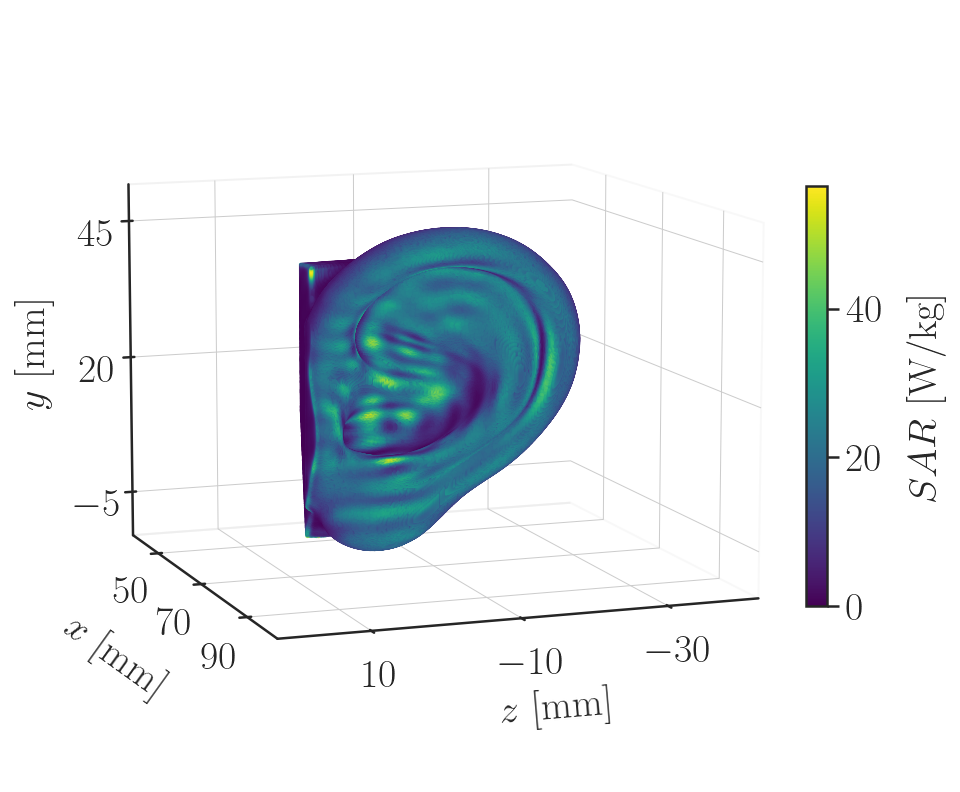

In [6]:
skip = 2
scaler = 2
fig_config(latex=True, text_size=20, scaler=scaler)
fig = plt.figure()
ax = plt.axes(projection ='3d')
cs = ax.scatter(xyz[::skip, 2], xyz[::skip, 0], xyz[::skip, 1],
                c=SAR[::skip],
                cmap='viridis',
                s=0.5,
               )
cbar = fig.colorbar(cs, shrink=0.55, pad=0)
cbar.ax.set_ylabel('$SAR$ [W/kg]')
cbar.ax.yaxis.labelpad = 12
ax.set(xlabel='$z$ [mm]', ylabel='$x$ [mm]',
       xticks=[10, -10, -30],
       yticks=[50, 70, 90],
       zticks=[-5, 20, 45])
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('$y$ [mm]', rotation=90)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 12
ax.view_init(10, 70)
ax = set_axes_equal(ax)
fig.tight_layout();

# save figure
fname = os.path.join('figures', f'{polarization}{f}_sar')
save_fig(fig, fname=fname, formats=['png'])